# COM v.s. COM の解析
[View on nbviewer](http://nbviewer.ipython.org/gist/Ushiki/050e40e087d211403b22)

In [1]:
from os import path
import glob
import re
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## データの読み込みと整形
ログファイルを開いて、csvからpandasのDataFrameオブジェクトを作る  
まずは2つのレベルから作ったstrをキーとした辞書にし、  
それら全てをマージした一つのDataFrame df_mergeを作る

In [2]:
dirname = path.expanduser('~/asobi/python/TicTacToe/analysis/comcom_log_v1.0')
pat = re.compile(path.join(dirname, r'log_(\d)_(\d).csv'))
df_dict = {}
for fname in glob.glob(path.join(dirname, 'log*.csv')):
    df = pd.read_csv(
        fname,
        names=('level1', 'level2', 'winner', 'elapsed', 'n', 'moves')
    )
    # winnerは0: draw, 1: COM1, 2: COM2だが平均などを考える時のために、2 -> -1とする
    df.loc[df.winner == 2, 'winner'] = -1
    m = pat.match(fname)
    level1, level2 = m.group(1, 2)
    df_dict[level1+'_'+level2] = df
df_merge = pd.concat(df_dict.values())

In [3]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 99
Data columns (total 6 columns):
level1     10000 non-null int64
level2     10000 non-null int64
winner     10000 non-null int64
elapsed    10000 non-null float64
n          10000 non-null int64
moves      10000 non-null object
dtypes: float64(1), int64(4), object(1)
memory usage: 546.9+ KB


In [4]:
df_merge.describe()

,level1,level2,winner,elapsed,n
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.500000,4.500000,0.204800,7.281075,7.712500
std,2.872425,2.872425,0.713518,9.409411,1.408844
min,0.000000,0.000000,-1.000000,0.000000,5.000000
25%,2.000000,2.000000,0.000000,0.383250,7.000000
50%,4.500000,4.500000,0.000000,3.083000,8.000000
75%,7.000000,7.000000,1.000000,10.467000,9.000000
max,9.000000,9.000000,1.000000,38.265000,9.000000


|  カラム名|       説明|
|:--------:|:---------:|
|**level1**|先攻のlevel|
|**level2**|後攻のlevel|
|**winner**|対戦結果<br>0: draw, 1: COM1, -1: COM2|
|**elapsed**|試合終了までの時間 [sec]|
|**n**|試合終了までの手数|

## プロット用の関数定義
下の関数で用いるグローバル変数

In [5]:
levels = range(10)

level1, level2をx軸にただ散布図をプロットする

In [6]:
def plot_scatter(column, ylabel, logscale=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # df_merge.plot(kind='scatter', x='level1', y=column, ax=axes[0], title='level1')
    # df_merge.plot(kind='scatter', x='level2', y=column, ax=axes[1], title='level2')
    for i, x, c in zip([0, 1], ['level1', 'level2'], ['b', 'r']):
        axes[i].plot(df_merge[x], df_merge[column], marker='o', ms=5, mec=c, mfc=c, alpha=0.2, linestyle='none')
        axes[i].set_xlabel(x)
        axes[i].grid()
    if logscale:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
    axes[0].set_ylabel(ylabel)
    plt.show()

---
level1, level2でグループ分けして、平均、平均±標準偏差を折れ線で表示

In [7]:
def plot_groupby(colmun, loc='upper, left', logscale=False, invert=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    colors = plt.cm.jet(np.linspace(0, 1, len(levels)))
    for l, c in zip(levels, colors):
        l1_mean = df_merge[df_merge.level2 == l].groupby('level1').mean()
        l2_mean = df_merge[df_merge.level1 == l].groupby('level2').mean()
        l1_std = df_merge[df_merge.level2 == l].groupby('level1').std()
        l2_std = df_merge[df_merge.level1 == l].groupby('level2').std()
        l1_mean.plot(y=colmun, ax=axes[0], label=l, color=c)
        l2_mean.plot(y=colmun, ax=axes[1], label=l, color=c)
        l1_upper, l1_lower = l1_mean + l1_std, l1_mean - l1_std
        l2_upper, l2_lower = l2_mean + l2_std, l2_mean - l2_std
        axes[0].fill_between(l1_mean.index, l1_lower[colmun], l1_upper[colmun], color=c, alpha=0.2)
        axes[1].fill_between(l2_mean.index, l2_lower[colmun], l2_upper[colmun], color=c, alpha=0.2)
    axes[0].set_ylabel(colmun)
    if logscale:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
    axes[1].legend(loc=loc)
    if invert:
        ymin, ymax = axes[1].set_ylim()
        axes[1].set_ylim(ymax, ymin)
    plt.show()

---
level1, level2でグループ分けしたものを平均値をとってカラーマップでプロット

In [8]:
level_group = df_merge.groupby(['level1', 'level2']).mean()
print level_group.head(11)
def plot_colormap(colmun, title):
    data = []
    for level1 in levels:
        data.append([level_group[colmun][level1][level2] for level2 in levels])
    plt.figure(figsize=(8, 8))
    plt.imshow(data, interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('level1')
    plt.ylabel('level2')
    plt.xticks(levels)
    plt.yticks(levels)
    plt.grid()
    plt.show()

               winner  elapsed     n
level1 level2                       
0      0         0.25  0.00009  7.70
       1        -0.10  0.00157  6.72
       2        -0.58  0.00628  7.42
       3        -0.58  0.03018  7.20
       4        -0.69  0.13226  7.12
       5        -0.73  0.44445  7.17
       6        -0.78  1.27559  7.04
       7        -0.81  2.36646  6.97
       8        -0.75  3.21042  7.15
       9        -0.75  3.18200  7.03
1      0         0.63  0.00209  6.33


---
## カラムごとのプロットと考察
### elapsed time
まずはlevel1, level2をx軸として、elapsed timeの散布図を見てみる  
(最初はpandasでプロットしたが、細かいスタイルの設定がわからなかったから、matplotlibでプロットした)

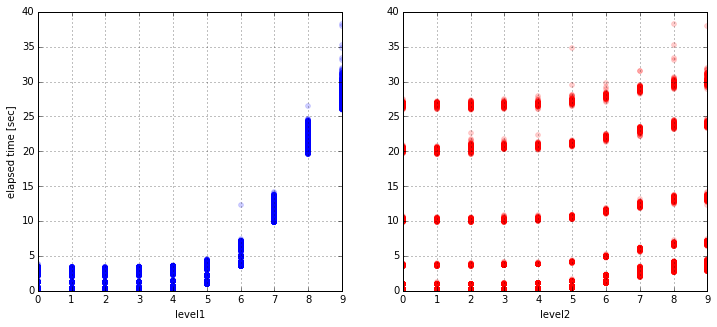

In [9]:
plot_scatter('elapsed', 'elapsed time [sec]', logscale=False)

level1, level2ではelapsed timeの挙動が大きく異なることがわかる。  
level1の方では予想していたとおり、概ね指数関数的に増加している。  
level2の方はlevel1の方と比較して、x軸に対する変化は少なく、  
他の要因による変化が大きく、それはおそらくlevel1だと思われる。

---
右上の図のlevel2に対する解釈をより進めるために、  
level1でグループ分けしたものの平均と標準偏差を取り、  
平均±標準偏差をプロットする。

同様に左上のlevel1に対しても同じことをする。

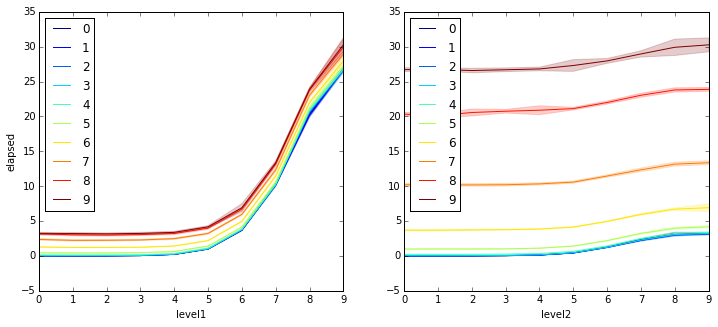

In [10]:
plot_groupby('elapsed', 'upper left', False)

左図のlevel1に対する図から読み取れることは、

- level1が[0, 7]は指数関数的に上昇し、[7, 9]はその上昇が緩やかになっている
- 先攻のlevel1に対する変化に対して、後攻のlevel2に対する変化はとても小さい

どちらも3目並べが、ゲームを進めるたびに選択肢が少なくなる、という性質に基づいたものである。levelを上げゲーム木の探索の深さを上げると、分岐の数が指数関数的に大きくなるが、levelを上げても各分岐での選択肢が少なくなっていくため、上昇が緩やかになるからである。

対して右図のlevel2からは、

- 変化の仕方はlevl1に対するものと似ている
- 後攻のlevel2に対する変化に比べて、level1に対する変化が大きい

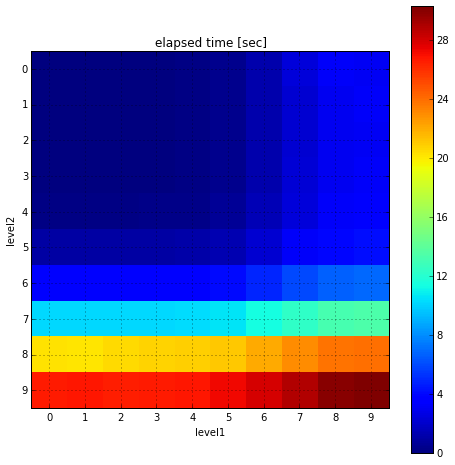

In [11]:
plot_colormap('elapsed', 'elapsed time [sec]')

---
経過時間は2つのレベルの和でよく表すことができると思ったが、
下の散布図を見る限りでは、そうではないらしい

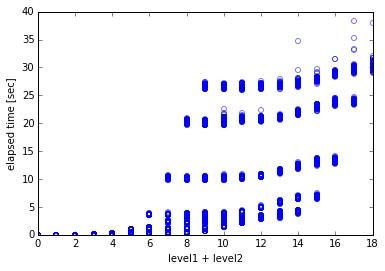

In [12]:
# df_levelsum = pd.DataFrame()
# df_levelsum['levelsum'] = df_merge[['level1', 'level2']].sum(axis=1)
# df_levelsum['elapsed'] = df_merge['elapsed']
# df_levelsum.plot(kind='scatter', x='levelsum', y='elapsed')
plt.plot(df_merge.level1 + df_merge.level2, df_merge.elapsed,
         'o', mec='b', mfc='none', ms=5, alpha=0.2)
plt.ylabel('elapsed time [sec]')
plt.xlabel('level1 + level2')
plt.show()

---
### winner
同様のプロットをwinnerに対して  
(winner: -1が後攻の勝ちなので、level1の方と揃えるためにy軸を反転)

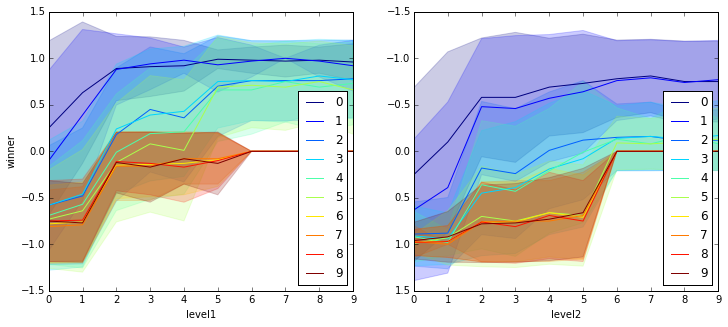

In [13]:
plot_groupby('winner', 'lower right', False, invert=True)

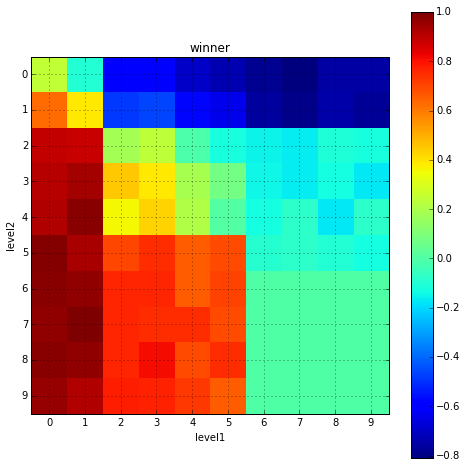

In [14]:
plot_colormap('winner', 'winner')

---
### number of moves: n
同様にmovesの数nにたいしても

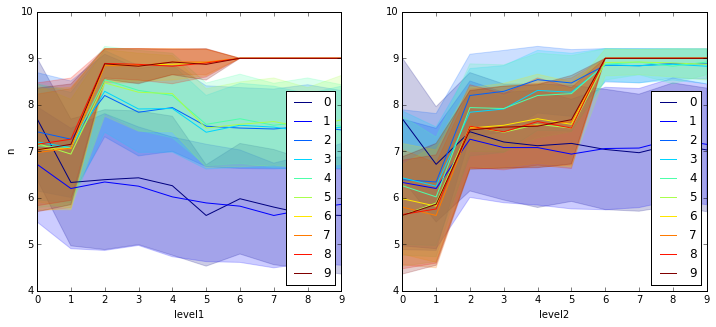

In [15]:
plot_groupby('n', 'best', False, False)

青色のプロットでlevelが上がるとnが減少する傾向にある。  
これは、今回minmax法の中で採用した評価関数scoreが浅いところのほうが点数が高くなるようになっているため、先を読む深さが増し、早く終了させられる手がわかったからと考えられる。

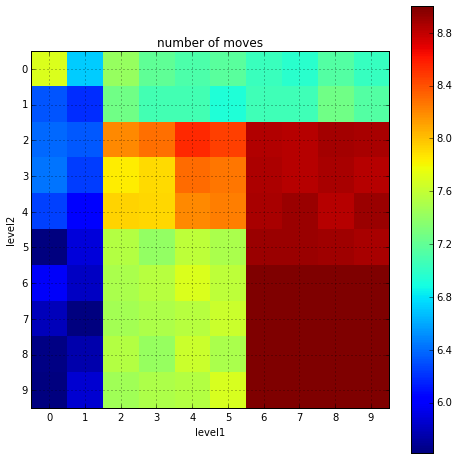

In [16]:
plot_colormap('n', 'number of moves')